# Search In Practice- Approximate Nearest Neighbors 🔎

In [ ]:
# Additional Resources 📚

# Motivation 🎇

- Used to find similar entries

- Recommendation systems

- Search engines

- Spell checking

- [Many more](https://en.wikipedia.org/wiki/Nearest_neighbor_search#Applications)

# Nearest Neighbors

![](nearest-neighbours1.png)

![](nearest-neighbours2.png)

# Our Dataset 💾

- Use the movielens dataset 

- Contains 100k rows with X dimentions

In [1]:
import pickle
import faiss

In [2]:
def load_data():
    with open('movies.pickle', 'rb') as f:
        data = pickle.load(f)
    return data

data = load_data()
vectors = data["vector"]
names = data["name"]
data

{'name': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'vector': array([[-0.01780608, -0.14265831,  0.10308606, ...,  0.09659795,
         -0.17529577, -0.03061521],
        [-0.03357764,  0.16418771,  0.21801303, ...,  0.16502103,
         -0.09166156,  0.05047869],
        [-0.2761452 , -0.01991325, -0.04969981, ...,  0.0258275 ,
         -0.08328608, -0.0152858 ],
        ...,
        [ 0.05142734, -0.01683608, -0.20441587, ...,  0.00045828,
          0.14679626,  0.2462584 ],
        [ 0.04491899, -0.02819411, -0.09472758, ..., -0.02152078,
          0.16223577,  0.19897607],
        [ 0.02531924,  0.03099714,  0.06437534, ..., -0.07260127,
          0.0467432 ,  0.07893164]], dtype=float32)}

In [5]:
faiss.MatrixStats(vectors).comments.split("\n")

['analyzing 1682 vectors of size 64',
 'no NaN or Infs in data',
 'all vectors are distinct',
 'range of L2 norms=[0.747558, 1.80436] (0 null vectors)',
 'matrix contains no 0s',
 'no constant dimensions',
 'no dimension has a too large mean',
 'stddevs per dimension are in [0.112036 0.158214]',
 '']

# Strategies for Exact Nearest Neighbors 🧠

- **Exhaustive Search**: Comparing each point to every other point, which will require Linear query time (the size of the dataset and the dimention ).


knn -> O(Nlogk)

- **The Grid Trick**: subdividing the space to a Grid, which will require exponential space/time (in the dimensionality of the dataset).


- kd trees
- quad-trees
- metric trees
- logn query time and n^(d/2) space

- [Since we are speaking on high dimension datasets the grid trick is impractical](http://www.vldb.org/conf/1998/p194.pdf).

# Exhaustive Search Using Faiss

- Support comparision using matrix multiplication or using loops

- Support multiple metrics

- Running as a batch


- Support GPU / CPU


- Cache Friendly

- A typical operation in IndexFlatL2 is to exhaustively compare a set of nq query vectors and a set of nb database vectors in dimension d (then select the top-k smallest vectors).
- Faiss has two implementations of this operation:
    - direct implementation that loops over nq, nb and the dimension of the vectors.
    - an implementation that uses the decomposition d(x, y) = ||x||^2 + ||y||^2 - 2 * <x, y>. This is faster because the most expensive operation in O(nq * nb * d) can be handed over to BLAS that normally does this efficiently.

We use implementation 1 when nq < 20, and implementation 2 otherwise. The threshold 20 can be adjusted via global variable faiss::distance_compute_blas_threshold (accessible in Python via faiss.cvar.distance_compute_blas_threshold).
Note that solution 2 may be less stable numerically than 1 for vectors of very different magnitudes, see discussion in issue #297.

- Faiss provides low-level functions to do the brute-force search in this context.
- The functions take a matrix of database vectors and a matrix of query vectors and return the k-nearest neighbors and their distances.

In [3]:
index = faiss.IndexFlatL2(vectors.shape[1])
index.add(vectors)

In [4]:
search_vector = vectors[90:91]
distances, indices = index.search(search_vector, 10)

In [5]:
print(f"The most similar movies to {names[90]} are:\n")
print([names[i] for i in indices[0]])

The most similar movies to Nightmare Before Christmas, The (1993) are:

['Nightmare Before Christmas, The (1993)', 'Heavy Metal (1981)', 'Sirens (1994)', 'Beauty and the Beast (1991)', 'Akira (1988)', 'Fantasia (1940)', 'Benny & Joon (1993)', 'Barbarella (1968)', "Pete's Dragon (1977)", 'James and the Giant Peach (1996)']


# But It’s Not All Rainbows And Unicorns 🦄

- Most modern-day applications have massive datasets with high dimensionality.

- Linear scan will take a while. 

- Additional constraints such as reasonable memory consumption and/or low latency.

- The only method guaranting exact nearest neighbor is exhaustive search

![](storage-tradeoff.png)

![](https://miro.medium.com/max/1336/0*Nt8sGnZm0sBwa2Fs.jpg)

# Approximate Nearest Neighbors’ Motivation 🎇

- Enable fast searches

- While controling Memory, Precision, and Performance  tradeoffs 

- Can do full calculation after entries being fetched

# Strategies for approximate nearest neighbors 🧠

- **Vector Transformation** — applied on vector before they are indexed.

amongst them there is dimensionality reduction and vector rotation.

- **Vector Encoding** — applied on vectors in order to construct the actual index for search.

amongst these there are data structure-based techniques like Trees, LSH and Quantization a technique to encode the vector to a much more compact form.


- **None Exhaustive Search Component** — applied on vectors in order to avoid exhaustive search. 

amongst these techniques there are Inverted Files and Neighborhood Graphs

# None Exhaustive Search Component IVF

- We can avoid the exhaustive search 


- Partition our dataset in such a way that on search, we only query relevant partitions.


- Most datasets are actually multi-modal

![](https://miro.medium.com/max/1400/0*VSXhuU1WyAgEu4tJ.png)

- Dividing the dataset up this way reduce accuracy 


- You can search for multiple partitions 


- Time/accuracy tradeoff sweet spot.


![](https://miro.medium.com/max/960/0*By82lS1oF4UtEy7Z.gif)

In [6]:

quantizer = faiss.IndexFlatL2(vectors.shape[1])
index = faiss.IndexIVFFlat(quantizer, 
                           vectors.shape[1], 
                           100,             # number_of_partition,
                           8)               # search_in_x_partitions
index.train(vectors)
index.add(vectors)

In [ ]:
search_vector = vectors[90:91]
distances, indices = index.search(search_vector, 10)

In [ ]:
print(f"The most similar movies to {names[90]} are:\n")
print([names[i] for i in indices[0]])

# Vector Encoding using Product Quantization

- reduce the size of the dataset by replacing every vector with a leaner approximated representation of the vectors 

- Give similar vectors to the same representation.

- This can be done by clustering similar vectors and represent each of those as the centroid

- We can use k-means again

This will allow us to represent each vector in a much more efficient way log(k) bit per vector since each vector can be represented in the label of the centroid.

- In our example, each vector is represented by one of the centroids. 
- since we have 2042 centroids we can represent each vector with 11 bits, as opposed to 4096 ( 1024*32 ).

![](https://miro.medium.com/max/1400/0*_DeC1LZgJKR9NEJ-.jpeg)
   

- This amazing compaction comes with a great cost 

- we lose accuracy as we now cant separate the original vector from the centroid.

- to increase the accuracy of our vectors we need to increase drastically the number of centroids

- makes regurlar Quantization phase infeasible in practice.

- Gave birth to Product Quantization 

- We can increase the number of centroids by dividing each vector into many vectors and run our quantizer on all of these.


- In our example, each vector is represented by 8 sub-vectors which can be represented by one of the centroids. 


- Since we have 256 centroids we can represent each matrix in 1 byte


- Making vector representation 8byte only as oppose to 4096 ( 1024*32 ).


![](https://miro.medium.com/max/1400/0*rU8Qhmd2d-zeYKwI.jpeg)

Although it increases the size of the vector a bit compared to the regular quantizer, it’s still O(log(k)) and allows us to increase the accuracy drastically and still work in practice.
Unfortunately in terms of search, even though we can calculate the distances in more efficiently using table look-ups and some addition. We are still going to do an exhaustive search.
    In our example, this means that this means building a table of subvector distances with 256 rows (one for each centroid) and 8 columns (one for each subvector). Remember that each database vector is now just a sequence of 8 centroid ids.
The exact nearest neighb
![](https://miro.medium.com/max/1400/0*Aa60Tq3Agbb5dmjt.jpeg)

In [8]:
quantizer = faiss.IndexFlatL2(vectors.shape[1])
index = faiss.IndexIVFPQ(quantizer, 
                         vectors.shape[1], 
                         100,             # number_of_partition,
                         8,               # search_in_x_partitions, 
                         8)               # subvector_size
index.train(vectors)
index.add(vectors)

In [9]:
search_vector = vectors[90:91]
distances, indices = index.search(search_vector, 10)


In [10]:
print(f"The most similar movies to {names[90]} are:\n")
print([names[i] for i in indices[0]])

The most similar movies to Nightmare Before Christmas, The (1993) are:

['Nightmare Before Christmas, The (1993)', 'Heavy Metal (1981)', 'Pink Floyd - The Wall (1982)', 'Akira (1988)', 'Hamlet (1996)', 'Full Metal Jacket (1987)', 'Supercop (1992)', 'Scream of Stone (Schrei aus Stein) (1991)', 'Scream of Stone (Schrei aus Stein) (1991)', 'Scream of Stone (Schrei aus Stein) (1991)']


# [Guidelines to choose an index](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index)


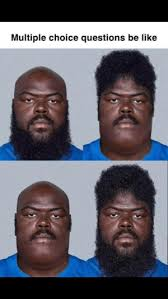

# Higher Level Vector Search 

- [milvus](https://github.com/milvus-io/milvus)

- vector similarity search engine powered by Faiss, NMSLIB and Annoy
- Support regular database features
- support adding vectors
- Doesn't support all the features and work on CPU

- [jina](https://github.com/jina-ai/jina)

![](https://cdn.educba.com/academy/wp-content/uploads/2015/11/43.jpg)

# Additional Resources 📚

- [Exact Nearest Neighbors Algorithms](https://www.youtube.com/watch?v=EipAOnj6bF0)

- [Comprehensive Guide To Approximate Nearest Neighbors Algorithms](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)
- [Billion-scale Approximate Nearest Neighbor Search](https://www.youtube.com/watch?v=CjEttJBWr90)
- [An Introduction to Faiss and Similarity Search](https://www.youtube.com/watch?v=Un1Q92lfhPM)


- [Approximate nearest neighbors and vector models, introduction to Annoy](https://www.youtube.com/watch?v=QkCCyLW0ehU)


- [Scaling Visual Search with Locally Optimized Product Quantization](
https://www.youtube.com/watch?v=AQau4-VF64w)

- [Approximate Nearest Neighbors in Limited Space](https://www.youtube.com/watch?v=_UvkFgiAZqE)

- [Algo Hour - Nearest Neighbor Descent (and friends)](https://www.youtube.com/watch?v=OvT2NY_FV_g&feature=emb_title)
- [Fast Scalable Approximate Nearest Neighbor Search for High-dimensional Data](https://www.youtube.com/watch?v=CjEttJBWr90)

![](https://i.pinimg.com/originals/b9/0a/79/b90a79b4c361d079144597d0bcdd61de.jpg)

keeping imageindex fresh
remove duplicate images from our index

- do not insert very similar vectors